“Yelp Inc. (NYSE: YELP) connects people with great local businesses. Yelp was founded in San Francisco in July 2004. Since then, Yelp communities have taken root in major metros across 32 countries. By the end of Q4 2018, Yelpers had written approximately 177 million rich, local reviews, making Yelp the leading local guide for real word-of-mouth on everything from boutiques and mechanics to restaurants and dentists. Approximately 33 million unique devices* accessed Yelp via the Yelp app, approximately 69 million unique visitors visited Yelp via mobile web** and approximately 62 million unique visitors visited Yelp via desktop*** on a monthly average basis during Q4 2018.”

Yelp is a website that offers users an opportunity to leave recommendations for various types of businesses. Yelp also acts a social platform, users are able to have ‘friends’ and rate this ‘friends’ reviews. 
Each year, Yelp provides a data set that that includes information from local business in 10 metropolitan areas across two countries with the aim of having students research or analyze on this data and share their discoveries.

Yelp reviewers leave "stars" for the businesses that they are reviewing and each business has an aggragate number of "stars" indicating whether they are a good business or an unfavorable business.

Utilizing the Yelp dataset, the objective of our project is two fold. First we will look at the the social influence that Yelp Elite users have within the Yelp network by focusing on the links in the bipartite network. Do businesses were Elite users have left recommendations often have more recommendations than other restaurants?  

Second, we will build a sentiment analysis of user reviews from the Yelp dataset. We will attempt to find out whether Elite Users tend to leave more positive or negative reviews and based on those reviews, if the business then receives more positive or negative stars. 

Overall, this analysis will focus on the influence that Elite Yelp users have on business ratings.


In [ ]:
#Packages needed to run program
import requests
import re
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
from collections import Counter 

# graph viz
import plotly
import plotly.offline as pyo
from plotly.graph_objs import *
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec 
from wordcloud import *

#graph section
import networkx as nx

#natural language section
import string
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from textblob import TextBlob


#machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.svm import LinearSVC
import ast


%matplotlib inline

First, we load each of the datasets from their JSON format to a pandas dataframe. It's important to look at each dataframe and figure out what values are in each column.

In [2]:
tips = []
for line in open('/Users/ntlrsmllghn/Dropbox/Data/Data 620/Final/yelp_dataset/tip.json', 'r'):
    tips.append(json.loads(line))

tips_df = pd.DataFrame(tips)
tips_df.head()

,business_id,compliment_count,date,text,user_id
0,VaKXUpmWTTWDKbpJ3aQdMw,0,2014-03-27 03:51:24,"Great for watching games, ufc, and whatever el...",UPw5DWs_b-e2JRBS-t37Ag
1,OPiPeoJiv92rENwbq76orA,0,2013-05-25 06:00:56,Happy Hour 2-4 daily with 1/2 price drinks and...,Ocha4kZBHb4JK0lOWvE0sg
2,5KheTjYPu1HcQzQFtm4_vw,0,2011-12-26 01:46:17,Good chips and salsa. Loud at times. Good serv...,jRyO2V1pA4CdVVqCIOPc1Q
3,TkoyGi8J7YFjA6SbaRzrxg,0,2014-03-23 21:32:49,The setting and decoration here is amazing. Co...,FuTJWFYm4UKqewaosss1KA
4,AkL6Ous6A1atZejfZXn1Bg,0,2012-10-06 00:19:27,Molly is definately taking a picture with Sant...,LUlKtaM3nXd-E4N4uOk_fQ


In [3]:
tips_df.shape

(1223094, 5)

In [4]:
business = []
for line in open('/Users/ntlrsmllghn/Dropbox/Data/Data 620/Final/yelp_dataset/business.json', 'r'):
    business.append(json.loads(line))
business_df = pd.DataFrame(business)
business_df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


In [5]:
business_df.shape

(192609, 14)

In [6]:
review = []
for line in open('/Users/ntlrsmllghn/Dropbox/Data/Data 620/Final/yelp_dataset/review.json', 'r'):
    review.append(json.loads(line))
review_df = pd.DataFrame(review)
review_df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


In [7]:
review_df.shape

(6685900, 9)

In [8]:
user = []
for line in open('/Users/ntlrsmllghn/Dropbox/Data/Data 620/Final/yelp_dataset/user.json', 'r'):
    user.append(json.loads(line))
user_df = pd.DataFrame(user)
user_df.head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,4.03,1,0,1,2,0,0,1,0,1,...,25,"2015,2016,2017",5,"c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",17,Rashmi,95,84,l6BmjZMeQD3rDxWUbiAiow,2013-10-08 23:11:33
1,3.63,1,0,1,1,0,0,0,0,0,...,16,,4,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",22,Jenna,33,48,4XChL029mKr5hydo79Ljxg,2013-02-21 22:29:06
2,3.71,0,0,0,0,0,0,1,0,0,...,10,,0,"4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...",8,David,16,28,bc8C_eETBWL0olvFSJJd0w,2013-10-04 00:16:10
3,4.85,0,0,0,1,0,0,0,0,2,...,14,,5,"RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN6A...",4,Angela,17,30,dD0gZpBctWGdWo9WlGuhlA,2014-05-22 15:57:30
4,4.08,80,0,80,28,1,1,16,5,57,...,665,"2015,2016,2017,2018",39,"mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6DeQ...",279,Nancy,361,1114,MM4RJAeH6yuaN8oZDSt0RA,2013-10-23 07:02:50


In [9]:
user_df.shape

(1637138, 22)

In order to see the review for each business, we must combine the business dataframe and review dataframe. The common column that they both share is the `business_id` column. 

In [10]:
business_review_df = pd.merge(business_df, review_df, how='inner', on='business_id')

In [11]:
business_review_df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,...,stars_x,state,cool,date,funny,review_id,stars_y,text,useful,user_id
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,...,3.0,AZ,0,2015-09-24 00:02:23,0,BUgmey6v6hZ1WfjbIhpVBg,1.0,Don't go here if you expect consistent or reas...,2,WS95iyoiDkbLGeHtERa1-A
1,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,...,3.0,AZ,0,2016-04-02 03:41:15,0,jL1fWnCQV8tLdpo2sKDYuQ,4.0,Both courses are great! You can find reasonabl...,0,vvOJpbXO4E3d3g0AFEl9mA
2,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,...,3.0,AZ,0,2015-03-27 00:21:38,0,HFUFnkhInL3xwdUnONJ6AA,5.0,Absolutely gorgeous facility. Golf course was...,0,Gjj9cj_EsFgwmn-jrjJfeQ
3,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,...,3.0,AZ,0,2015-09-23 01:40:31,0,IBf9CaGl0BDJhbaadp7A3g,4.0,Played for the first there this past weekend a...,0,ce63dEP3lIW6UqMGLe_lfw
4,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,...,3.0,AZ,1,2016-05-19 00:50:17,0,jvZCtKsHjVhPcp7oqjLI0A,1.0,I was invited to a golf outing being held here...,0,T_f8EzM9vebLHoDU5PDcWA


The number of rows for this dataframe is equal to the review column lenght. Our merge was successful.

In [12]:
business_review_df.shape

(6685900, 22)

In [13]:
business_review_df.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'postal_code',
       'review_count', 'stars_x', 'state', 'cool', 'date', 'funny',
       'review_id', 'stars_y', 'text', 'useful', 'user_id'],
      dtype='object')

Since some of the columns shared the same names, we had to rename columns.

In [14]:
business_review_df.rename(columns={'name_x': 'business_name', 'stars_x':'average_stars','stars_y': 'reviewer_star'}, inplace=True)

In [15]:
business_review_df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,...,average_stars,state,cool,date,funny,review_id,reviewer_star,text,useful,user_id
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,...,3.0,AZ,0,2015-09-24 00:02:23,0,BUgmey6v6hZ1WfjbIhpVBg,1.0,Don't go here if you expect consistent or reas...,2,WS95iyoiDkbLGeHtERa1-A
1,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,...,3.0,AZ,0,2016-04-02 03:41:15,0,jL1fWnCQV8tLdpo2sKDYuQ,4.0,Both courses are great! You can find reasonabl...,0,vvOJpbXO4E3d3g0AFEl9mA
2,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,...,3.0,AZ,0,2015-03-27 00:21:38,0,HFUFnkhInL3xwdUnONJ6AA,5.0,Absolutely gorgeous facility. Golf course was...,0,Gjj9cj_EsFgwmn-jrjJfeQ
3,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,...,3.0,AZ,0,2015-09-23 01:40:31,0,IBf9CaGl0BDJhbaadp7A3g,4.0,Played for the first there this past weekend a...,0,ce63dEP3lIW6UqMGLe_lfw
4,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,...,3.0,AZ,1,2016-05-19 00:50:17,0,jvZCtKsHjVhPcp7oqjLI0A,1.0,I was invited to a golf outing being held here...,0,T_f8EzM9vebLHoDU5PDcWA


In order to find out more about the elite user rewiews, we have to merge a third dataframe to the business and review dataframes. The common column that these dataframe share is `user_id`.

In [16]:
master_df = pd.merge(business_review_df, user_df, how='inner', on='user_id')

In [17]:
master_df.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name_x', 'postal_code',
       'review_count_x', 'average_stars_x', 'state', 'cool_x', 'date',
       'funny_x', 'review_id', 'reviewer_star', 'text', 'useful_x', 'user_id',
       'average_stars_y', 'compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool_y',
       'elite', 'fans', 'friends', 'funny_y', 'name_y', 'review_count_y',
       'useful_y', 'yelping_since'],
      dtype='object')

There are a number of columns within this dataframe that are not useful for our analysis, so we will drop them.

In [17]:
master_df = master_df.drop(columns=['compliment_cool', 'compliment_funny', 'compliment_hot', 'compliment_list', 'compliment_more',
                        'compliment_note', 'compliment_photos', 'compliment_cute', 'compliment_plain', 'compliment_profile',
                       'compliment_writer'])

As before, there are columns with the same name, so we will rename these columns.

In [18]:
master_df.rename(columns={'review_count_x': 'business_review_cnt', 'average_stars_x':'business_avg_stars', 'cool_x':'cool_business_review',
                          'funny_x': 'funny_business_review', 'useful_x':'useful_business_review', 'name_y':'user_name', 
                          'average_stars_y': 'user_avg_stars', 'cool_y':'cool_user_reviews', 'funny_y':'funny_user_reviews',
                          'review_count_y':'user_review_cnt', 'useful_y':'useful_user_reviews'}, inplace=True)

checking the shape of the new master dataframe, we find that this dataframe is the same lenght as the `business_df` dataframe.

In [20]:
master_df.shape

(6685900, 43)

In [21]:
master_df.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name_x', 'postal_code',
       'business_review_cnt', 'business_avg_stars', 'state',
       'cool_business_review', 'date', 'funny_business_review', 'review_id',
       'reviewer_star', 'text', 'useful_business_review', 'user_id',
       'user_avg_stars', 'compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer',
       'cool_user_reviews', 'elite', 'fans', 'friends', 'funny_user_reviews',
       'user_name', 'user_review_cnt', 'useful_user_reviews', 'yelping_since'],
      dtype='object')

Now that we have loaded all the data, let's do an exploratory analysis of our data.

First, we should find out what type of businesses are reviewed by Yelp?

In [22]:
category_list = set()
for business in business_df['categories'][business_df['categories'].notnull()].str.split(','):
    business = [x.strip(' ') for x in business]
    category_list = set().union(business, category_list)
category_list = list(category_list)

In [23]:
category_count = []
for cat in category_list:
    category_count.append([cat,business_df['categories'].str.contains(cat).sum()])

names = ['category_name','category_count']
category_df = pd.DataFrame(data=category_count, columns=names)
category_df.sort_values("category_count", inplace=True, ascending=False)
category_df.head(10)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



,category_name,category_count
241,Restaurants,59371
1236,Food,36527
811,Shopping,31878
417,Home Services,19729
937,Beauty & Spas,19370
903,Health & Medical,17171
955,Bars,15340
969,Local Services,13932
296,Automotive,13203
1048,Nightlife,13095


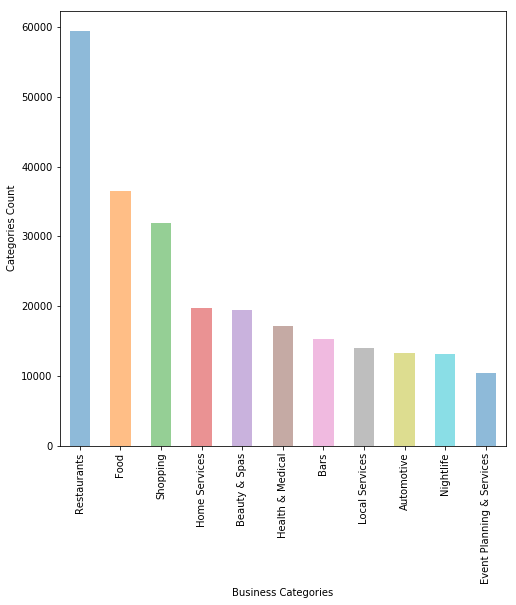

In [24]:
plt.subplots(figsize=(8, 8))
labels=category_df['category_name'][category_df['category_count']>10000]
category_df['category_count'][category_df['category_count']>10000].plot.bar( align='center', alpha=0.5)
y_pos = np.arange(len(labels))
#plt.yticks(y_pos, labels)
plt.xticks(y_pos, labels)
plt.xlabel('Business Categories')
plt.ylabel('Categories Count')

plt.show()

Restaurants, Food, and Shopping are the top three categories reviewed on Yelp. 

Which cities are featured in this data?

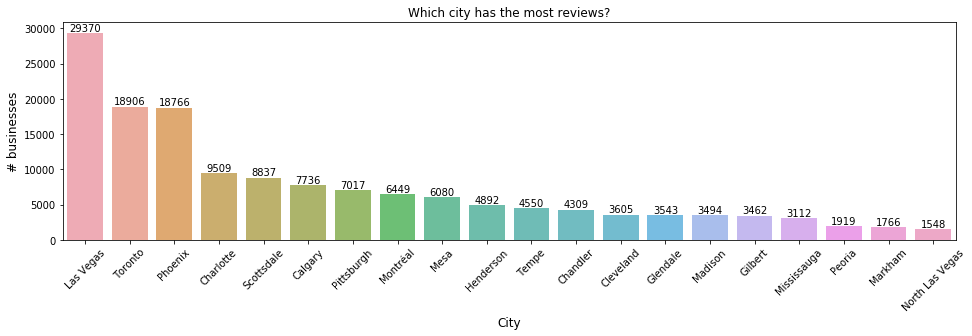

In [25]:
x=business_df['city'].value_counts()
x=x.sort_values(ascending=False)
x=x.iloc[0:20]
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Which city has the most reviews?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('City', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [26]:
top_cities = business_df.city.value_counts()
top_cities.head(20)

Las Vegas          29370
Toronto            18906
Phoenix            18766
Charlotte           9509
Scottsdale          8837
Calgary             7736
Pittsburgh          7017
Montréal            6449
Mesa                6080
Henderson           4892
Tempe               4550
Chandler            4309
Cleveland           3605
Glendale            3543
Madison             3494
Gilbert             3462
Mississauga         3112
Peoria              1919
Markham             1766
North Las Vegas     1548
Name: city, dtype: int64

Within this dataset, Las Vegas, Toronto, and Phoenix have the most reviews. 

It would be interesting to see what the average number of stars these cities have.

In [ ]:
city_business_reviews = business_df[['city', 'review_count', 'stars']].groupby(['city']).\
agg({'review_count': 'sum', 'stars': 'mean'}).sort_values(by='review_count', ascending=False)
city_business_reviews.head(10)

,review_count,stars
city,,
Las Vegas,1965651,3.696170
Phoenix,706761,3.646808
Toronto,510856,3.444409
Scottsdale,372805,3.932500
Charlotte,299233,3.539594
Pittsburgh,218776,3.602893
Henderson,210596,3.760221
Tempe,195082,3.688681
Mesa,161847,3.628207


Which business have the most reviews? Let's take a look at the top 25 most reviewed businesses.

In [27]:
business_df[['name', 'review_count', 'city', 'stars']].sort_values(ascending=False, by="review_count")[0:25]

,name,review_count,city,stars
82250,Mon Ami Gabi,8348,Las Vegas,4.0
89206,Bacchanal Buffet,8339,Las Vegas,4.0
35199,Wicked Spoon,6708,Las Vegas,3.5
58852,Hash House A Go Go,5763,Las Vegas,4.0
141820,Gordon Ramsay BurGR,5484,Las Vegas,4.0
83950,Earl of Sandwich,5075,Las Vegas,4.5
174616,The Buffet,4400,Las Vegas,3.5
89437,The Cosmopolitan of Las Vegas,4322,Las Vegas,4.0
29614,Secret Pizza,4286,Las Vegas,4.0
1975,The Buffet at Bellagio,4227,Las Vegas,3.5


Each of these businesses are located in Las Vegas. Likely, this is because there are more reviews in the dataset for businesses in Las Vegas.

Let's see how stars are distributed within this dataset.

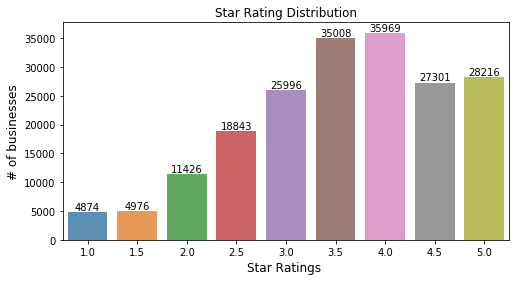

In [28]:
x=business_df['stars'].value_counts()
x=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [29]:
business_df['stars'].value_counts()

4.0    35969
3.5    35008
5.0    28216
4.5    27301
3.0    25996
2.5    18843
2.0    11426
1.5     4976
1.0     4874
Name: stars, dtype: int64

3.5 to 5 stars make up most of the reviews. Let's see if that means that there will be more positive sentiment than a negative one.

Is there any correlation between the number of stars and the length of the review? Or how useful/cool/or funny the reviews are?

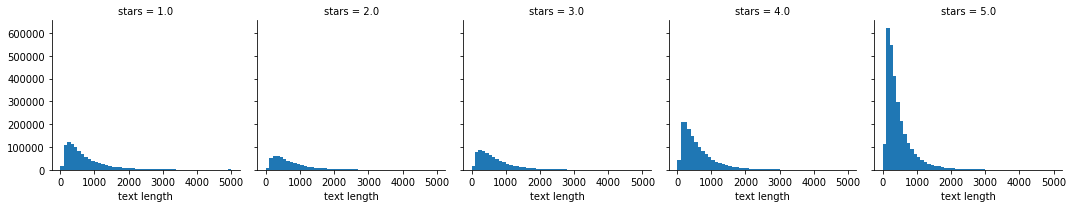

In [34]:
review_df['text length'] = review_df['text'].apply(len)
g = sns.FacetGrid(data=review_df, col='stars')
g.map(plt.hist, 'text length', bins=50)

In [35]:
stars = review_df.groupby('stars').mean()
stars

,cool,funny,useful,text length
stars,,,,
1.0,0.243788,0.616449,2.054681,760.444319
2.0,0.399765,0.623617,1.582709,762.703278
3.0,0.672871,0.609040,1.377155,710.315383
4.0,0.860899,0.570298,1.382258,624.224334
5.0,0.561312,0.335379,1.052618,481.532439


In [36]:
stars.corr()

,cool,funny,useful,text length
cool,1.000000,-0.173444,-0.679328,-0.469384
funny,-0.173444,1.000000,0.717921,0.946166
useful,-0.679328,0.717921,1.000000,0.817055
text length,-0.469384,0.946166,0.817055,1.000000


From the matrix, looks like the 1-star and 2-star ratings have much longer text - maybe text length won’t be such a useful feature to consider after all.

Looking at the matrix, funny is strongly correlated with useful, and useful seems strongly correlated with text length. We can also see a negative correlation between cool and the other three features. Maybe funny reviews are longer than useful and cool reviews.

Which businesses have the top rated reviews in the data?

In [40]:
review_df['name'] = review_df['business_id'].map(business_df.set_index('business_id')['name'])
top_rated = review_df.name.value_counts().index[:20].tolist()
top_rated

['Starbucks',
 "McDonald's",
 'Hash House A Go Go',
 'Chipotle Mexican Grill',
 'Mon Ami Gabi',
 'Bacchanal Buffet',
 'Buffalo Wild Wings',
 'In-N-Out Burger',
 'Wicked Spoon',
 'Panera Bread',
 "Denny's",
 'Subway',
 'The Cheesecake Factory',
 "Dunkin' Donuts",
 'Earl of Sandwich',
 'Yard House',
 "Oregano's Pizza Bistro",
 "Grimaldi's Pizzeria",
 'Discount Tire',
 'Gordon Ramsay BurGR']

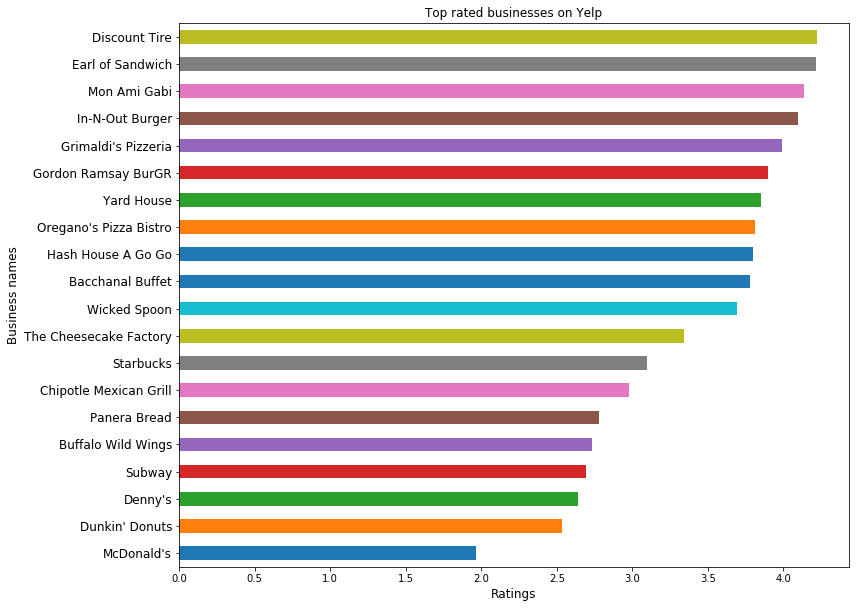

In [41]:
df_review_top = review_df.loc[review_df['name'].isin(top_rated)]
df_review_top.groupby(df_review_top.name)['stars'].mean().sort_values(ascending=True).plot(kind='barh',figsize=(12, 10))
plt.yticks(fontsize=12)
plt.title('Top rated businesses on Yelp',fontsize=12)
plt.ylabel('Business names', fontsize=12)
plt.xlabel('Ratings', fontsize=12) 
plt.show()

Now that we have a sense of what the business, reviews, and distribution of stars look like, we want to start looking at the social network of Yelp Reviews and Businesses.

In [42]:
user_df.describe()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool,fans,funny,review_count,useful
count,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06,1.637138e+06
mean,3.681462e+00,3.106818e+00,1.902082e-01,3.106818e+00,2.242225e+00,8.358489e-02,3.325951e-01,1.503944e+00,1.138432e+00,3.090273e+00,2.135135e-01,1.165329e+00,2.188046e+01,1.465646e+00,1.791785e+01,2.228770e+01,4.052770e+01
std,1.151040e+00,8.823263e+01,1.269798e+01,8.823263e+01,8.021821e+01,1.089557e+01,1.367850e+01,6.327596e+01,9.549144e+01,9.211418e+01,1.626675e+01,3.268262e+01,4.019675e+02,1.568317e+01,3.303504e+02,7.692236e+01,4.702421e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00
50%,3.890000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,3.000000e+00
75%,4.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,3.000000e+00,1.500000e+01,1.300000e+01
max,5.000000e+00,3.226600e+04,1.365400e+04,3.226600e+04,3.416700e+04,1.266900e+04,1.350000e+04,5.783300e+04,8.260200e+04,5.210300e+04,1.417300e+04,1.544200e+04,1.486580e+05,9.538000e+03,1.302070e+05,1.327800e+04,1.542020e+05


In [43]:
print(user_df.dtypes)

average_stars         float64
compliment_cool         int64
compliment_cute         int64
compliment_funny        int64
compliment_hot          int64
compliment_list         int64
compliment_more         int64
compliment_note         int64
compliment_photos       int64
compliment_plain        int64
compliment_profile      int64
compliment_writer       int64
cool                    int64
elite                  object
fans                    int64
friends                object
funny                   int64
name                   object
review_count            int64
useful                  int64
user_id                object
yelping_since          object
dtype: object


In [44]:
#convert string to timestampe
user_df['joined']= pd.to_datetime(user_df['yelping_since'])
#group by year and count occurrences
yearGrouping =user_df.groupby(user_df['joined'].map(lambda x : x.year))['yelping_since'].count()
user_df['number of Friends'] = pd.to_numeric(user_df['friends'], errors='coerce').fillna(0)
user_df['number of Friends']=user_df['number of Friends'].astype(np.int64)
user_df['elite']=pd.to_numeric(user_df['elite'],errors='coerce').fillna(0)
user_df['elite']=user_df['elite'].astype(np.int64)                                                                   
#user_df['target'] = user_df['elite']!='[]'
print(user_df.dtypes)

average_stars                float64
compliment_cool                int64
compliment_cute                int64
compliment_funny               int64
compliment_hot                 int64
compliment_list                int64
compliment_more                int64
compliment_note                int64
compliment_photos              int64
compliment_plain               int64
compliment_profile             int64
compliment_writer              int64
cool                           int64
elite                          int64
fans                           int64
friends                       object
funny                          int64
name                          object
review_count                   int64
useful                         int64
user_id                       object
yelping_since                 object
joined                datetime64[ns]
number of Friends              int64
dtype: object


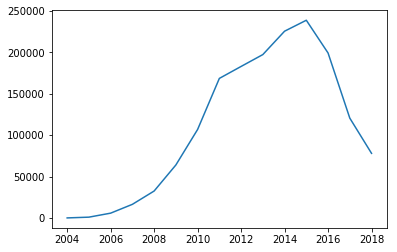

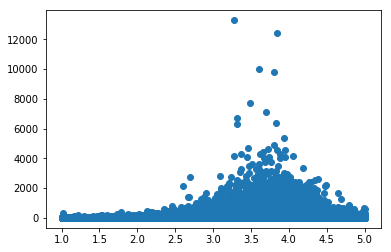

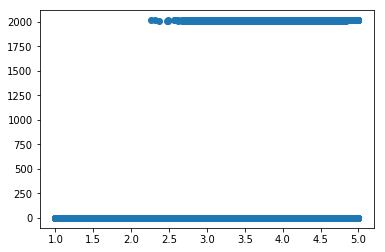

In [45]:
plt.figure()
plt.plot(yearGrouping)
plt.figure()
plt.scatter(user_df['average_stars'],user_df['review_count'])
plt.figure()
plt.scatter(user_df['average_stars'],user_df['elite'])

In [47]:
print(len(user_df['elite']))
print(max(user_df['elite']))
print(min(user_df['elite']))

1637138
2018
0


In [48]:
# elite users
elite_df = user_df.nlargest(20, 'elite')
#elite_df['friends'] = elite_df['friends'].apply( lambda x : ast.literal_eval(x))

# creating graph and adding edges
eg = nx.Graph()
for i in elite_df.index:
    for j in elite_df.loc[i,'friends']:
        eg.add_edge(elite_df.loc[i,'user_id'], j)

print(len(eg.edges()))
print(len(eg.nodes()))

1320
86


66


/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



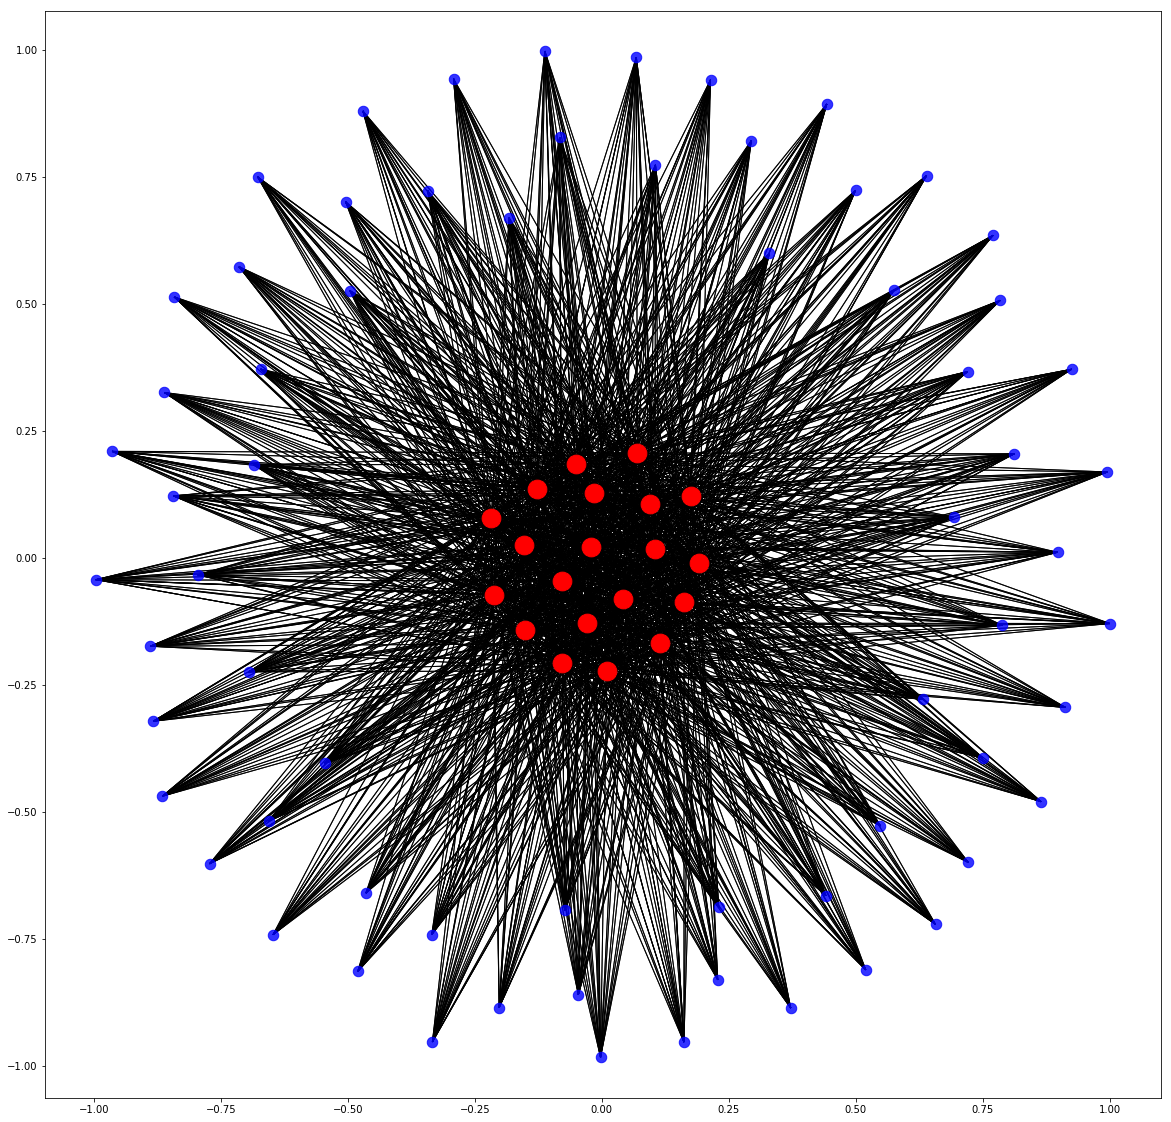

In [49]:
# drawing graph
elite_nodes = []
for i in elite_df.index:
    elite_nodes.append(elite_df.loc[i, 'user_id'])

#print elite_nodes
extra_nodes = []
for node in eg.nodes():
    if node not in elite_nodes:
        extra_nodes.append(node)
print(len(extra_nodes))

plt.figure(figsize=(20,20))
plt.axis('equal')
pos = nx.spring_layout(eg)
nx.draw_networkx(eg, pos, node_color = 'b', with_labels = False, nodelist=extra_nodes, node_size=110, alpha=0.8)
nx.draw_networkx(eg, pos, node_color = 'r', with_labels = False, nodelist=elite_nodes, node_size=350, aplha=0.8)
plt.savefig('spring_20_elite.png')
plt.show()

In [50]:
# calculating betweenness of each node
betweenness = nx.closeness_centrality(eg)
print('done')
for i in elite_nodes:
    print(betweenness[i])

done
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923
0.8173076923076923


In [55]:
#subset users who have atleast 200 friends
subset_users=user_df[user_df['friends']!=200]
#user has given atleast 10 reviews
subset_users=subset_users[subset_users['review_count']>=10]
#subset_users=subset_users.sort_values('review_count',ascending=False)

subset_users['list_friends']=subset_users["friends"].apply(lambda x: str(x).split(','))

subset_users=subset_users[['user_id','list_friends']]
#stopping at 6k due to space constraints
subset_users=subset_users.iloc[0:6000]
res = subset_users.set_index(['user_id'])['list_friends'].apply(pd.Series).stack()

In [56]:
network_data=res.reset_index()
#checks
network_data.tail()

,user_id,level_1,0
2966170,LgulEqVMflVLv9x7V0fV0g,132,7yxdiZxeNQ0PkrTTU2f2HA
2966171,LgulEqVMflVLv9x7V0fV0g,133,Q6YA1jbr4hfkMtSB2QQNLA
2966172,LgulEqVMflVLv9x7V0fV0g,134,cVLsV6ixS3EvSfqqEcEjfg
2966173,LgulEqVMflVLv9x7V0fV0g,135,T498oe7LcnfEDrbU18_8Xg
2966174,LgulEqVMflVLv9x7V0fV0g,136,LE6reoWMs-iy9qYbO-5n5Q


In [63]:
#changing the column name to suit nx import
network_data.columns=['source','level_1','target']
# Considering each (user_id,friend) pair as an edge of a graph, constructing the graph
graph=nx.from_pandas_edgelist(network_data)

In [64]:
print(nx.info(graph))
#check density
print("The density of the graph is ",nx.density(graph))

Name: 
Type: Graph
Number of nodes: 1258227
Number of edges: 2966175
Average degree:   4.7148
The density of the graph is  3.747219300393894e-06


In [65]:
#use degree-centrality to find out influencers in the selected region
import heapq  # for getting top n number of things from list,dict
x=nx.degree_centrality(graph)
#Creating a subset again as we cant handle 70k nodes, unfortunately.

#Using heapq to find the 2000 most connected nodes (ie) peeple with the most connections
elite=heapq.nlargest(2000, x, key=x.get)

In [66]:
elite_sub_graph=graph.subgraph(elite)

# Check for isolates ( nodes with no edges (ie) users without friends in the sub-graph)
# graph=graph.remove_nodes_from(nx.isolates(graph))
list_of_nodes_to_be_removed=[x for x in nx.isolates(elite_sub_graph)]

# remove the selected isolates from the main graph
graph.remove_nodes_from(list_of_nodes_to_be_removed)

In [67]:
print(nx.info(elite_sub_graph))
#check density
print("The density of the graph is ",nx.density(elite_sub_graph))

Name: 
Type: Graph
Number of nodes: 1552
Number of edges: 19821
Average degree:  25.5425
The density of the graph is  0.016468424096193344


/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



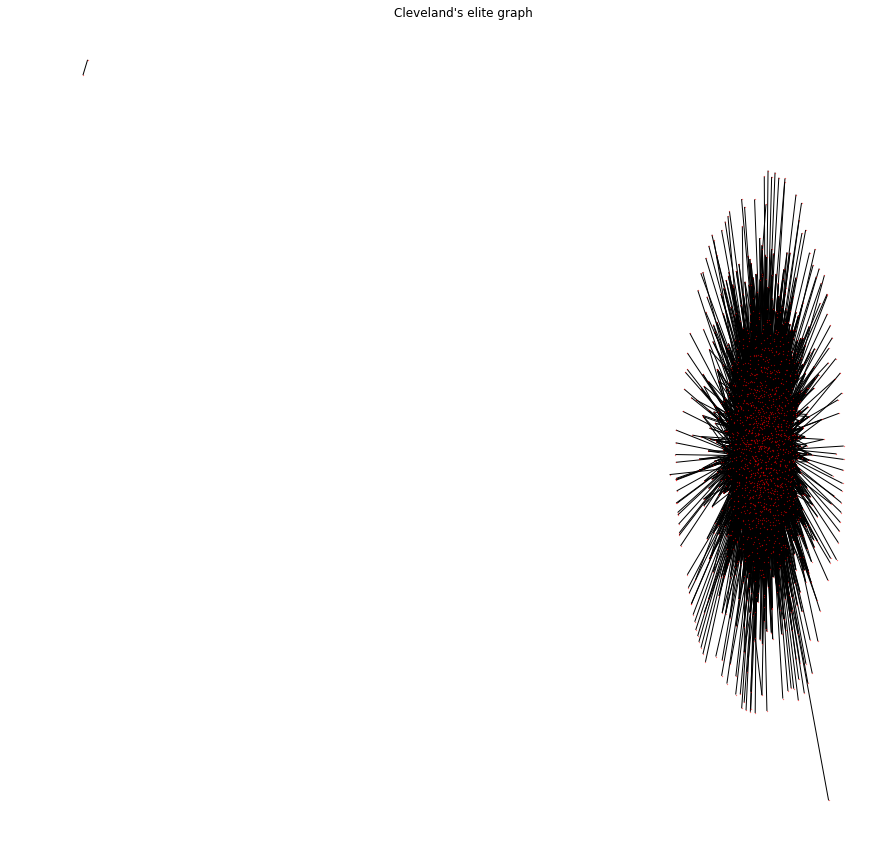

In [68]:
# create the layout
pos = nx.spring_layout(elite_sub_graph)
plt.figure(figsize=(15,15))
plt.title("Cleveland's elite graph")
nx.draw(elite_sub_graph, pos=pos, node_size=0.05, width=1)

Now ...

Let's see if elite users are more likely to leave positive or negative reviews on businesses and if this seems to impact the number of stars that a business has.

First, we subset elite users from the master dataframe.

In [69]:
elite_user_df = master_df[master_df['elite'].str.contains("201", na = False)]

In [70]:
elite_user_df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name_x,...,compliment_writer,cool_user_reviews,elite,fans,friends,funny_user_reviews,user_name,user_review_cnt,useful_user_reviews,yelping_since
45,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,...,3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00
46,"8333 Kennedy Road, Suite 1078","{'OutdoorSeating': 'False', 'RestaurantsPriceR...",NX1281ugzs2navHAX5X9cQ,"Bubble Tea, Food, Restaurants, Taiwanese, Coff...",Markham,"{'Monday': '12:0-0:0', 'Tuesday': '12:0-0:0', ...",1,43.856327,-79.303884,Cha Me Cha,...,3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00
47,8380 Kennedy Road,"{'Alcohol': 'u'none'', 'BusinessParking': '{'g...",5H4coiGpvG3XdnU1Nde2xQ,"Restaurants, Chinese",Markham,"{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ...",1,43.860726,-79.304713,Keung's Restaurant,...,3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00
48,"1480 Major Mackenzie Drive E, Unit 7","{'RestaurantsReservations': 'True', 'BikeParki...",SvMBtzXfE-3H5pxoR7VD3w,"Restaurants, Chinese",Richmond Hill,None,0,43.883345,-79.388160,Kenny's Gourmet,...,3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00
49,"360 Highway 7 E, Unit 3","{'OutdoorSeating': 'False', 'BikeParking': 'Fa...",PFAvETr4Vf6UY548TWvhFA,"Restaurants, Canadian (New), Japanese, Ramen",Richmond Hill,"{'Tuesday': '17:0-21:0', 'Wednesday': '17:0-21...",1,43.841523,-79.397015,Koi Sakana Ramen House,...,3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00


In [71]:
elite_user_df.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name_x', 'postal_code',
       'business_review_cnt', 'business_avg_stars', 'state',
       'cool_business_review', 'date', 'funny_business_review', 'review_id',
       'reviewer_star', 'text', 'useful_business_review', 'user_id',
       'user_avg_stars', 'compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer',
       'cool_user_reviews', 'elite', 'fans', 'friends', 'funny_user_reviews',
       'user_name', 'user_review_cnt', 'useful_user_reviews', 'yelping_since'],
      dtype='object')

In [72]:
elite_user_df.shape

(1559043, 43)

Now, we will subset the `elite_users_df` by average business stars. If a business has less than 3 stars, we will assume that the business will have negative reviews. If the business has an average of between 3 and 4 stars, we will classify it as having neutral reviews, and if the business has above 4 stars, we will classify the business as having positive reviews.

In [73]:
negative_reviws = elite_user_df[elite_user_df["business_avg_stars"]<3]
neutral_reviews = elite_user_df[(elite_user_df["business_avg_stars"]>=3) & (elite_user_df["business_avg_stars"]<4)]
positive_reviews = elite_user_df[elite_user_df["business_avg_stars"]>=4]

In [74]:
negative_reviws.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name_x,...,compliment_writer,cool_user_reviews,elite,fans,friends,funny_user_reviews,user_name,user_review_cnt,useful_user_reviews,yelping_since
45,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,...,3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00
51,11 Fairburn Dr,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...",fMt-wU8Topyja7u9qPJaqQ,"Vietnamese, Restaurants",Markham,"{'Monday': '11:0-21:0', 'Wednesday': '11:0-21:...",0,43.848061,-79.348680,Yummy Pho,...,3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00
65,21 Queensway W,"{'ByAppointmentOnly': 'False', 'AcceptsInsuran...",mhHkKNrD2qgDYpnFvFGITA,"Walk-in Clinics, Doctors, Medical Centers, Hea...",Mississauga,"{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ...",1,43.573885,-79.608430,Multispecialty Walkin Clinic,...,3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00
77,77 Adelaide Street W,"{'OutdoorSeating': 'True', 'RestaurantsPriceRa...",bSNKVZ-lXgKkms60vfPDsw,"Bars, Pubs, Nightlife",Toronto,"{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",1,43.649333,-79.382471,Duke of Westminster,...,3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00
82,4 4188 Living Arts Drive,"{'OutdoorSeating': 'False', 'RestaurantsDelive...",nozYAoGZi0xtElvHZ-PWMg,"Middle Eastern, Halal, Restaurants, Fast Food",Mississauga,"{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",1,43.590147,-79.648249,Osmow's,...,3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00


In [75]:
negative_reviws.shape

(123810, 43)

In [ ]:
neutral_reviews.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name_x,...,user_avg_stars,cool_user_reviews,elite,fans,friends,funny_user_reviews,user_name,user_review_cnt,useful_user_reviews,yelping_since
46,"8333 Kennedy Road, Suite 1078","{'OutdoorSeating': 'False', 'RestaurantsPriceR...",NX1281ugzs2navHAX5X9cQ,"Bubble Tea, Food, Restaurants, Taiwanese, Coff...",Markham,"{'Monday': '12:0-0:0', 'Tuesday': '12:0-0:0', ...",1,43.856327,-79.303884,Cha Me Cha,...,3.3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00
47,8380 Kennedy Road,"{'Alcohol': 'u'none'', 'BusinessParking': '{'g...",5H4coiGpvG3XdnU1Nde2xQ,"Restaurants, Chinese",Markham,"{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ...",1,43.860726,-79.304713,Keung's Restaurant,...,3.3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00
48,"1480 Major Mackenzie Drive E, Unit 7","{'RestaurantsReservations': 'True', 'BikeParki...",SvMBtzXfE-3H5pxoR7VD3w,"Restaurants, Chinese",Richmond Hill,None,0,43.883345,-79.388160,Kenny's Gourmet,...,3.3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00
49,"360 Highway 7 E, Unit 3","{'OutdoorSeating': 'False', 'BikeParking': 'Fa...",PFAvETr4Vf6UY548TWvhFA,"Restaurants, Canadian (New), Japanese, Ramen",Richmond Hill,"{'Tuesday': '17:0-21:0', 'Wednesday': '17:0-21...",1,43.841523,-79.397015,Koi Sakana Ramen House,...,3.3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00
50,2036 Yonge Street,"{'RestaurantsPriceRange2': '2', 'GoodForKids':...",LCb2moBNkcBto_32rmZJ5A,"Japanese, Sushi Bars, Buffets, Restaurants",Toronto,"{'Tuesday': '17:0-22:30', 'Wednesday': '17:0-2...",1,43.701275,-79.397533,Echo Sushi,...,3.3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00


In [ ]:
neutral_reviews.shape

(601621, 32)

In [76]:
positive_reviews.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name_x,...,compliment_writer,cool_user_reviews,elite,fans,friends,funny_user_reviews,user_name,user_review_cnt,useful_user_reviews,yelping_since
56,"1425 Dundas Street E, Suite 3","{'HasTV': 'False', 'RestaurantsPriceRange2': '...",dltDW0fS4HzxZ0A7PDT5jg,"Chinese, Dim Sum, Restaurants",Mississauga,None,1,43.610886,-79.584488,JAM House Seafood Restaurant,...,3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00
62,"4040 Creditview Road, Unit 22","{'HasTV': 'True', 'BusinessParking': '{'garage...",qGLEE1yA1bK0YdlGI-S39A,"Restaurants, Chinese, Food",Mississauga,"{'Monday': '10:30-19:30', 'Tuesday': '10:30-19...",1,43.568091,-79.666301,Wonton Chai Noodle,...,3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00
68,10411 Kennedy Road,"{'BusinessParking': '{'garage': False, 'street...",W4vwgcqpfV_Bf89Py4et8w,"Golf, Active Life",Markham,None,1,43.907189,-79.321258,Fairtree Golf Center,...,3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00
69,274 Parliament Street,"{'Ambience': '{'romantic': False, 'intimate': ...",YLc7Djf3GsC8IT84YkZMzw,"Thai, Restaurants",Toronto,"{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'...",1,43.658405,-79.365754,Sukhothai,...,3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00
72,299 Rathburn Road West,"{'RestaurantsPriceRange2': '3', 'BusinessParki...",_ECQWs8prRQaxHZv6-sv6Q,"Seafood, Restaurants, Steakhouses",Missisauga,"{'Monday': '11:30-23:0', 'Tuesday': '11:30-23:...",1,43.592718,-79.649409,Canyon Creek,...,3,20,"2017,2018",1,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",22,David,57,58,2014-11-27 22:36:00


In [77]:
positive_reviews.shape

(833612, 43)

Since the dataset has 1559043 reviews, I'm going to reduce the dataset to 100000. This is for the sake of my computer's processing abilities

In [88]:
elite_user_df = elite_user_df[:100000]

An initial step in text and sentiment classification is pre-processing. A significant amount of techniques is applied to data in order to reduce the noise of text, reduce dimensionality, and assist in the improvement of classification effectiveness. The most popular techniques include:

Remove numbers,
Stemming,
Part of speech tagging,
Remove punctuation,
Lowercase,
Remove stopwords

To build a classification algorithm will need some sort of feature vector in order to perform the classification task. The simplest way to convert a corpus to a vector format is the bag-of-words approach, where each unique word in a text will be represented by one number.

Let’s create a function that will split a review into individual words, return a list, and remove stop words (such as “the”, “a”, “an”, etc.). To do this, we can take advantage of the NLTK library. The function below removes punctuation, stopwords, and returns a list of the remaining words, or tokens.

First, let's get the average business stars

In [89]:
review_class = elite_user_df[(elite_user_df['business_avg_stars'] == 1) | (elite_user_df['business_avg_stars'] == 2)| (elite_user_df['business_avg_stars'] == 3)|(elite_user_df['business_avg_stars'] == 4)| (elite_user_df['business_avg_stars'] == 5)]
review_class.shape

(51326, 43)

Now, we will add assign `X` and `Y` to the two variables we want to use in our sentiment analysis. The text of a review by elite user and the average business stars.

In [90]:
X = review_class['text']
Y = review_class['business_avg_stars']

Creating a function for cleaning the data.

In [91]:
def clean_review(review):
    clean_data = [char for char in review if char not in string.punctuation]
    clean_data = ''.join(clean_data)
    
    return [word for word in clean_data.split() if word.lower() not in stopwords.words('english')]

Bag of Words to convert the text documents into a matrix of token counts

In [92]:
bag_of_word_transformer = CountVectorizer(analyzer=clean_review).fit(X)

We need to find out the shape of the sparse matrix, the amount of non-zero occurances, and the denistory of the non-zero values

In [94]:
X = bag_of_word_transformer.transform(X)
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print("Density: {}".format((density)))

Shape of Sparse Matrix:  (51326, 102316)
Amount of Non-Zero occurrences:  3957081
Density: 0.07535185832586151


Now we need a function to classify if a review is positive or negative

In [96]:
sent = 3
def classification(sent):
    if (sent == 3):
        if (sent < 3):
            print("negative")
    if ((sent >=3) & (sent <4)):
            print("neutral")
    else:
        print("positive")       

Next, let's transform a count matrix to a normalized tf or tf-idf representation

Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

In [98]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()  
X = tfidfconverter.fit_transform(X).toarray() 

Now, we are ready to split our dataset into train and test samples, 70% of the dataset 30% of the dataset is the test data.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

We will try a few different approaches to predicting if an elite user leaves a positive or negative review, what the average stars of the restaurant will be. 

The first approach will be to use the naive bayes model.

In [ ]:
naiveBayes = MultinomialNB()
naiveBayes.fit(X_train, Y_train)

In [ ]:
prediction = naiveBayes.predict(X_test)

print ("Prediction using Naive Bayes model\n")
for review in prediction:
    classification(review)

We will create a list that keeps track of our f1 scores for each of the models that we run.

In [ ]:
from sklearn.metrics import f1_score
f1_scr  = []
f1_scr.append(f1_score(Y_test,prediction,average='micro')*100)

Our next model will be a Linear Model

In [ ]:
svc = LinearSVC()
svc.fit(X_train, Y_train)

In [ ]:
prediction = svc.predict(X_test)
print ("Prediction using Linear SVC model\n")
for review in prediction:
    classification(review)

Append our f1 score list

In [ ]:
f1_scr.append(f1_score(Y_test,prediction,average='micro')*100)

Our third model will be a Logistical Regression Model.

In [ ]:
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression()
LogReg.fit(X_train, Y_train)

In [ ]:
prediction = LogReg.predict(X_test)

print ("Prediction using Logistic Regression model\n")
for review in prediction:
    classification(review)

In [ ]:
f1_scr.append(f1_score(Y_test,prediction,average='micro')*100)

Finally, let's try a Random Forest Classifier model to predict if an elite user leaves a review, will it have an impact of the overall stars a business has

In [93]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=18)
rf.fit(X_train, Y_train)

NameError: name 'X_train' is not defined

In [ ]:
prediction = rf.predict(X_test)
print ("Prediction using Random Forest Classifier model\n")
for review in prediction:
    classification(review)

In [ ]:
f1_scr.append(f1_score(B_test,prediction,average='weighted')*100)

In [ ]:
line1 = plt.plot (
          ['Naive Bayes','Linear SVC','LogisticRegression','RandomForest Classifier'],f1_scr ,'--o',alpha=0.7)
plt.title("Model Evaluation")
plt.ylabel('F1 score')
plt.xlabel('Models')
plt.show()